In [1]:
import pyvisa
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import date

rm = pyvisa.ResourceManager()
rm.list_resources()

K6487 = rm.open_resource('GPIB0::22::INSTR') # initialize Ammeter (Keithley 6487 Ammeter)
KDMM = rm.open_resource('GPIB0::16::INSTR') # initialize Digital Multimeter (Keithley 2000 Digital Multimeter)

In [25]:
runnum = 3 #We want to average the data of multiple runs to reduce error
runname = 'Si_-20C' # Used for file naming later

pause = 0.3 # Time between turning on V-source and taking data

Vmin = 0.01

#Vmax=0.29 #Ge_-20
#Vmax=0.28 #Ge_-10
#Vmax=0.265 #Ge_0
#Vmax=0.245 #Ge_10
#Vmax=0.235 #Ge_20

Vmax = 0.8 #Si_-20
#Vmax = 0.68 #Si_-10
#Vmax = 0.65 #Si_0
#Vmax = 0.63 #Si_10
#Vmax = 0.61 #Si_20

#Irange = 2E-2 #Ge Forward
#Irange = 2E-3 #Si Forward

n = 200

In [22]:
# Initializing and Setting Up Instruments

Volt = np.linspace(Vmin,Vmax,n) # Create an evenly space array of n values from Vmin to Vmax
Vmatrix = np.zeros((runnum,n)) # Create a runnum by n matrix of zeros to read voltage data into
Imatrix = np.zeros((runnum,n)) # Create a runnum by n matrix of zeros to read current data into

# K6487 Set Up
K6487.write('*RST') #Factory reset
#K6487.write('CURR:RANG %f' %Irange) # Set range for current measurement
K6487.write('FORM:ELEM READ') # Set form of reading to be just the measurement

# Setting Up Trigger for Ammeter
K6487.write('ARM:SOUR IMM') # Start immediately (upon arming it) rather than waiting for an external trigger
K6487.write('ARM:COUN 1') # Only run the arm once
K6487.write('TRIG:SOUR IMM') # Trigger immediately once arm has triggered
K6487.write('TRIG:COUN %i'%runnum) # Take runnum data points when triggered, delay is auto chosen based on I range
K6487.write('TRIG:DEL:AUTO ON') # Turn on the auto delay

# KDMM Set Up
KDMM.write('*RST') # Reset
KDMM.write('FORM:ELEM READ') # Set form of reading to be just the measurement
KDMM.write('CONF:VOLT') # Set to DC Volts
KDMM.write('SENS:VOLT:DC:RANG %f'%Vmax) # Set expected voltage range to Vmax

# Setting Up Trigger for DMM
KDMM.write('TRIG:SOUR IMM') # Set the trigger to go instantaneously (note there will be a delay inbetween measurements)
# Due to the way the K6487 calculates its auto delay, this needs to be set per trigger and is done so in the for loop
KDMM.write('SAMP:COUN %i'%runnum) # Take runnum data points when triggered

13

In [23]:
K6487.write('SYST:ZCH OFF') #Disable zero check

for i in range(n):

    K6487.write('SOUR:VOLT %f' % Volt[i]) # Set voltage source
    K6487.write('SOUR:VOLT:STAT ON') #Put V-source in Operate
    time.sleep(pause)
    KDMM.write('TRIG:DEL '+ K6487.query('TRIG:DEL?')) # Set trigger delay to be same as Ammeter

    I = np.array(K6487.query('READ?').split(','), dtype=float) # Take runnum data points and place them in a numpy array

    V = np.array(KDMM.query('READ?').split(','), dtype=float) # take runnum data points and place them in a numpy array

    Imatrix[:, i] = I # Make this data set the ith column of Imatrix
    Vmatrix[:, i] = V # Make this data set the ith column of Vmatrix

    K6487.write('SOUR:VOLT:STAT OFF') # Turn off V-Source

K6487.write('SYST:ZCH ON') #Enable zero check

Vavg = np.mean(Vmatrix, axis=0)
Iavg = np.mean(Imatrix, axis=0)

filepath = 'C:/Users/Physlab310/Desktop/Charulata and Nathan/' + str(date.today()) + '_' + runname
os.mkdir(filepath)

np.savetxt(filepath + '/V.txt', Vmatrix)
np.savetxt(filepath + '/I.txt', Imatrix)
np.savetxt(filepath + '/Vavg.txt', Vavg)
np.savetxt(filepath + '/Iavg.txt', Iavg)

print(runname + ' Data Collected and Saved')

Si_-10C Data Collected and Saved


Text(0, 0.5, 'Current (A)')

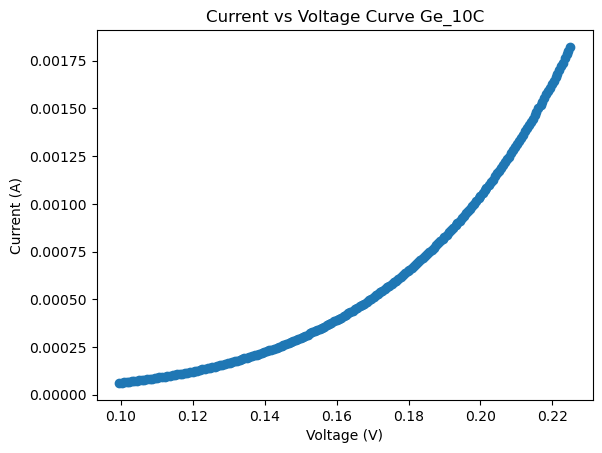

In [16]:
plt.scatter(Vavg,Iavg)
plt.title('Current vs Voltage Curve '+runname)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')